# Tutorial

Basic usage with an example dataset. Note, this tutorial uses the matplotlib graphing module which is *not* a dependency of ``AeroEvap``, be sure to install it to your environment before running this tutorial if you want the plots to display correctly.

In [2]:
import pandas as pd
import numpy as np
from aeroevap import Aero
from IPython.display import IFrame
import matplotlib.pyplot as plt
%matplotlib inline

## Example data 

This example uses buoy data from a location near south-central Lake Huron, MI (NOAA station ID is 45008). The buoy is maintained by the National Data Buoy Center (NDBC), more buoy information is shown in the embededd page below. The meterologicla data used in this example is hosted by NOAA and downloaded directly and formatted for a month of data. 

In [3]:
IFrame(src='https://www.ndbc.noaa.gov/station_page.php?station=45008', width=700, height=500)

The line below downloads the time series of current year buoy standard meterological data directly from the NDBC.

Input units:

| WDIR   | WSPD   | GST   | WVHT   | DPD   | APD   | MWD   | PRES   | ATMP   | WTMP   | DEWP   | VIS   | TIDE   |
|:-------|:-------|:------|:-------|:------|:------|:------|:-------|:-------|:-------|:-------|:------|:-------|
| degT   | m/s    | m/s   | m      | sec   | sec   | deg   | hPa    | degC   | degC   | degC   | nmi   | ft     |

In [4]:
# get standard meterological data from National Data Buoy Center
met_df = pd.read_csv(
    'https://www.ndbc.noaa.gov/data/l_stdmet/45008.txt', 
    delim_whitespace=True, skiprows=[1], na_values=[999.0]
)

Make a datetime index and clean up the dataframe.

In [5]:
met_df.index = pd.to_datetime(
    dict(
        year=met_df['#YY'], 
        month=met_df.MM, 
        day=met_df.DD, 
        hour=met_df.hh,
        minute=met_df.mm
    )
)
met_df.index.name = 'date'
met_df.drop(['#YY','MM','DD','hh','mm'], axis=1, inplace=True)
met_df.head()

,WDIR,WSPD,GST,WVHT,DPD,APD,MWD,PRES,ATMP,WTMP,DEWP,VIS,TIDE
date,,,,,,,,,,,,,
2019-08-01 00:00:00,344.0,3.3,3.9,99.00,99.0,99.00,NaN,1021.2,18.1,18.4,14.7,99.0,99.0
2019-08-01 00:10:00,342.0,3.3,3.9,99.00,99.0,99.00,NaN,1021.2,18.1,18.4,14.4,99.0,99.0
2019-08-01 00:20:00,344.0,3.4,3.9,99.00,99.0,99.00,NaN,1021.0,18.1,NaN,14.0,99.0,99.0
2019-08-01 00:30:00,343.0,3.2,3.9,99.00,99.0,99.00,NaN,1021.0,18.1,18.4,14.2,99.0,99.0
2019-08-01 00:40:00,341.0,3.3,3.9,0.27,3.7,2.81,335.0,1021.0,18.1,18.4,14.2,99.0,99.0


Because the input dataset does not include relative humitidy we can estimate it using an approximation to the Clausius–Clapeyron relation using air and dewpoint temperatures. Relative humitidy is needed in the aerodynamic mass-transfer evaporation calculations.

In [6]:
# vapor pressure and saturation vapor pressure using Clausius–Clapeyron relation
met_df['e'] = 0.611 * np.exp( 5423 * ((1/273) - (1/(met_df.DEWP+273.15))) )
met_df['es'] = 0.611 * np.exp( 5423 * ((1/273) - (1/(met_df.ATMP+273.15))) )

Text(0, 0.5, 'estimated relative humitidy')

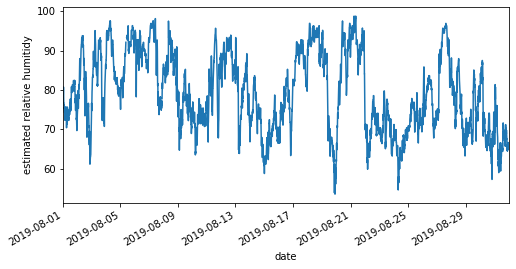

In [7]:
# calculate relative humitidy
met_df['RH'] = 100 * (met_df.e/met_df.es)

plt.figure(figsize=(8,4))
met_df.RH.plot()
plt.ylabel('estimated relative humitidy')

In this case we also need to convert air pressure to kPa, see below for required input units.

In [8]:
met_df.PRES = met_df.PRES / 10

# Create an ``Aero`` object

The ``Aero`` object allows for loading a ``pandas.DataFrame`` containing meterological data required for calculating aerodynamic mass-transfer open water evaporation in parrallel. The object can be initialized from a ``pandas.DataFrame`` or the ``pandas.DataFrame`` can be assigned later, e.g.

In [9]:
Aero_empty = Aero()
Aero_with_df = Aero(met_df)

In [10]:
Aero_empty.df is None

True

In [11]:
# the df property can be assigned after initialization:
Aero_empty.df = met_df

In [12]:
# the data has been added
Aero_empty.df.head()

,WDIR,WSPD,GST,WVHT,DPD,APD,MWD,PRES,ATMP,WTMP,DEWP,VIS,TIDE,e,es,RH
date,,,,,,,,,,,,,,,,
2019-08-01 00:00:00,344.0,3.3,3.9,99.00,99.0,99.00,NaN,102.12,18.1,18.4,14.7,99.0,99.0,1.702567,2.121383,80.257421
2019-08-01 00:10:00,342.0,3.3,3.9,99.00,99.0,99.00,NaN,102.12,18.1,18.4,14.4,99.0,99.0,1.669429,2.121383,78.695334
2019-08-01 00:20:00,344.0,3.4,3.9,99.00,99.0,99.00,NaN,102.10,18.1,NaN,14.0,99.0,99.0,1.626143,2.121383,76.654845
2019-08-01 00:30:00,343.0,3.2,3.9,99.00,99.0,99.00,NaN,102.10,18.1,18.4,14.2,99.0,99.0,1.647659,2.121383,77.669099
2019-08-01 00:40:00,341.0,3.3,3.9,0.27,3.7,2.81,335.0,102.10,18.1,18.4,14.2,99.0,99.0,1.647659,2.121383,77.669099


In [13]:
# this will not work, df needs to be a dataframe
Aero_empty.df = 'high five'

TypeError: Must assign a pandas.DataFrame object

**Tip:** the ``df`` is a property of the ``Aero`` class which means it can be assigned or reassigned if, for example, you wanted to run the evaporation calculations on a modified version of input meterological time series without creating a new ``Aero`` instance.

## Input variables and units

The meterological variables needed for running the aerodynamic mass-transfer estimation of evaporation are the following:

| variable          | units | naming |
|-------------------|-------|--------|
| wind speed        | m/s   | WS     |
| air pressure      | kPa   | P      |
| air temperature   | C     | T_air  |
| skin temperature  | C     | T_skin |
| relative humidity | 0-100 | RH     |

where the "naming" column refers to the internal names expected by the ``Aero.run`` method, i.e. the column headers in the dataframe should either be named accordingly or a dictionary that maps your column names to those internal names can be passed (see examples below). 

To run the evaporation calculation you will also need the anemometer height in meters and the temporal sampling frequency of the data in seconds.

## Run calculation on time series

In [14]:
# make a naming dict to match up columns with Aero variable names
names = {
    'WSPD' : 'WS',
    'ATMP' : 'T_air',
    'WTMP' : 'T_skin',
    'PRES' : 'P'
}

Now we are ready to run the aerodynamic mass-transer evaporation on all the time series in our dataframe. Lastly, the sensor height of the anemometer and temporal sampling frequency of the data needs to be supplied. 

This example assumes there are 8 physical and logical processors available for parallelization, if not specified the ``Aero.run`` routine wil try to use half of the avialble processors.

In [15]:
np.seterr('ignore')
# create a new Aero object and calculate evaporation on all rows
A = Aero(met_df)
A.run(sensor_height=4, timestep=600, variable_names=names)

After the calculations are complete three variables will be added to the ``Aero.df`` dataframe: 'E', 'Ce', and 'VPD' which are evaporation in mm/timestep, bulk transfer coefficient, and vapor pressure deficit (kPa). 

In [16]:
A.df[['E', 'Ce', 'VPD']].head()

,E,Ce,VPD
date,,,
2019-08-01 00:00:00,0.013349,0.001862,0.449526
2019-08-01 00:10:00,0.014311,0.001861,0.481971
2019-08-01 00:20:00,NaN,NaN,NaN
2019-08-01 00:30:00,0.014593,0.001874,0.503286
2019-08-01 00:40:00,0.014943,0.001861,0.503286


View the calculated evaporation,

Text(0, 0.5, 'evaporation mm/10 min')

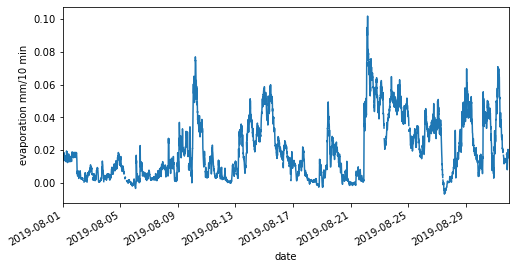

In [17]:
plt.figure(figsize=(8,4))
A.df.E.plot()
plt.ylabel('evaporation mm/10 min')

The calculated open-water evaporation is shown below after creating a daily sum.

Text(0, 0.5, 'evaporation mm/day')

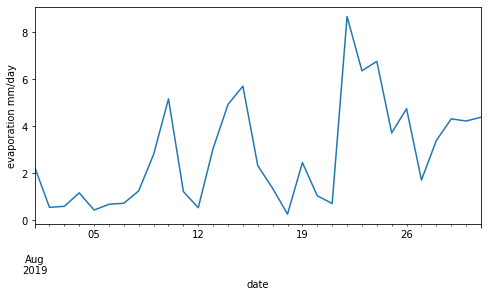

In [18]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,4))
A.df.E.resample('D').sum().plot()
plt.ylabel('evaporation mm/day')

And the wind speed relation versus the calculated evaporation.

Text(0.5, 0, 'mean daily wind speed m/s')

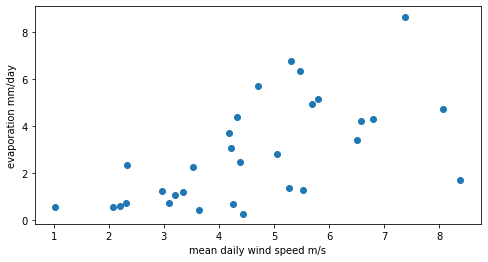

In [19]:
plt.figure(figsize=(8,4))
plt.scatter(A.df.WSPD.resample('D').mean(), A.df.E.resample('D').sum())
plt.ylabel('evaporation mm/day')
plt.xlabel('mean daily wind speed m/s')

## Single calculation

The ``Aero`` class also provides a method ``Aero.single_calc`` that can be used on a single set of meterological data to calculate the instantaneous open-water evaporation. It requires the same inputs as ``Aero.run`` however the inputs are scalars as opposed to time series. For example using the first timestamp of our example buoy data we can calculate E, Ce, and VPD:

In [24]:
datetime = '2019-08-01 00:00:00'
wind = 3.3
pressure = 102.12
T_air = 18.1
T_skin = 18.4
RH = 80.26
sensor_height = 4
timestep = 600

E, Ce, VPD = Aero.single_calc(
    datetime,
    wind,
    pressure,
    T_air,
    T_skin,
    RH,
    sensor_height,
    timestep
)

In [25]:
E, Ce, VPD

(0.013347901575421104, 0.0018616426530205339, 0.44947250457458576)